# Sarima model

## Učitavanje biblioteka

In [1]:
# Standardne biblioteke
import warnings     
import calendar      
import itertools   
from datetime import date   
import pickle

# Obrada podataka
import pandas as pd
import numpy as np

# Vizuelizacija
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns

# Statističke i matematičke funkcije
from scipy import stats
from scipy.stats import gaussian_kde, boxcox
from scipy.special import inv_boxcox
from scipy.signal import periodogram

# Time series modeliranje
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Machine learning modeli, metrika i evaluacija
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Progres bar za petlje
from tqdm import tqdm

# Lokalni notebook za grafove
%run 00_graphs.ipynb

# Isključenje upozorenja
warnings.filterwarnings('ignore')

c:\Users\lukam\anaconda3\envs\op_env\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## Učitavanje podataka

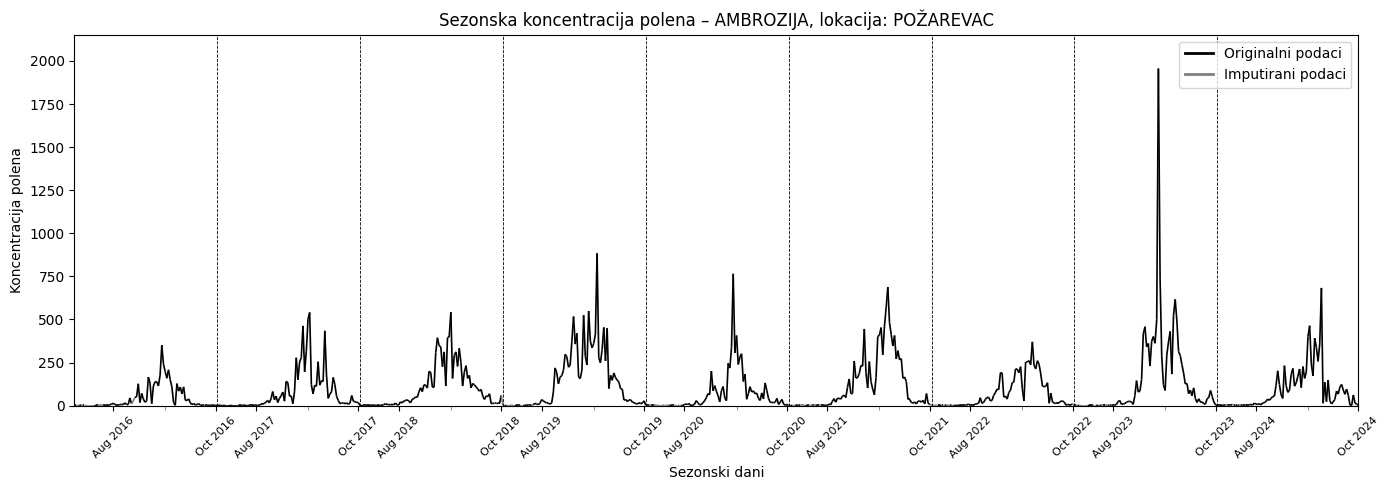

In [18]:
df = pd.read_csv('spatiotemporal_kriging_predictions.csv', parse_dates = ['date'])
location = 'POŽAREVAC'
allergen = 'AMBROZIJA'
data = df[(df.allergen == allergen) & (df.location == location)]
weather = pd.read_csv('meteo/meteo_df.csv', parse_dates=['date'])
data = pd.merge(left=data, right=weather, how='left', on=['date', 'location'])
end_date = pd.to_datetime('2024-01-01')
plot_seasonal_concentration_imp(data)

## Preprocesiranje

### log transformacija

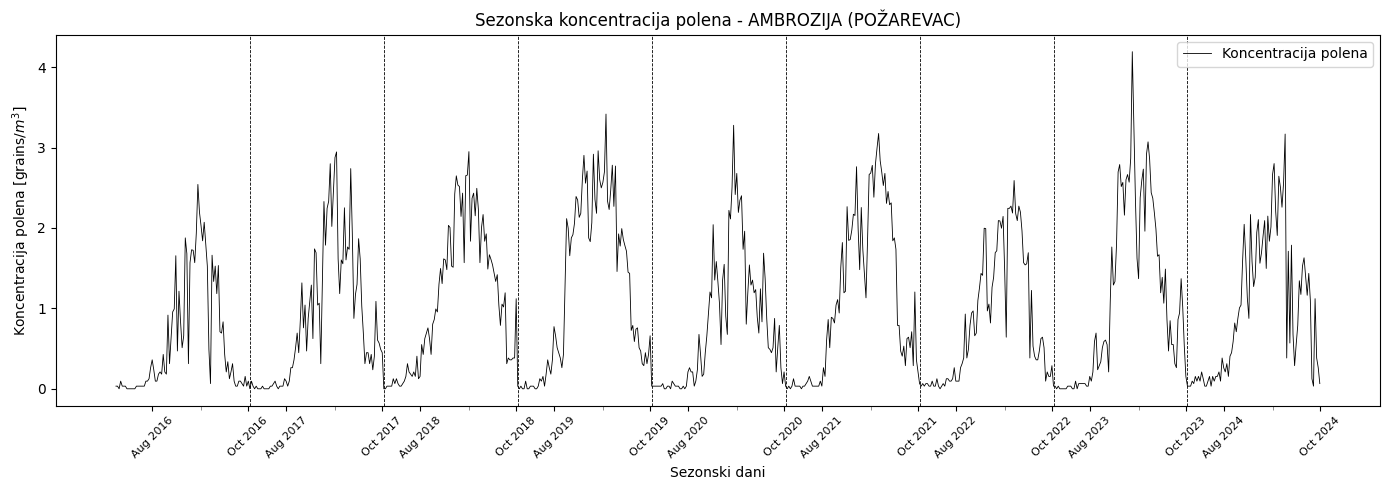

In [52]:
data['transform'] = np.log1p(data['value']/30)

plot_seasonal_concentration(data, col='transform')

### Određivanje perioda vremenske serije

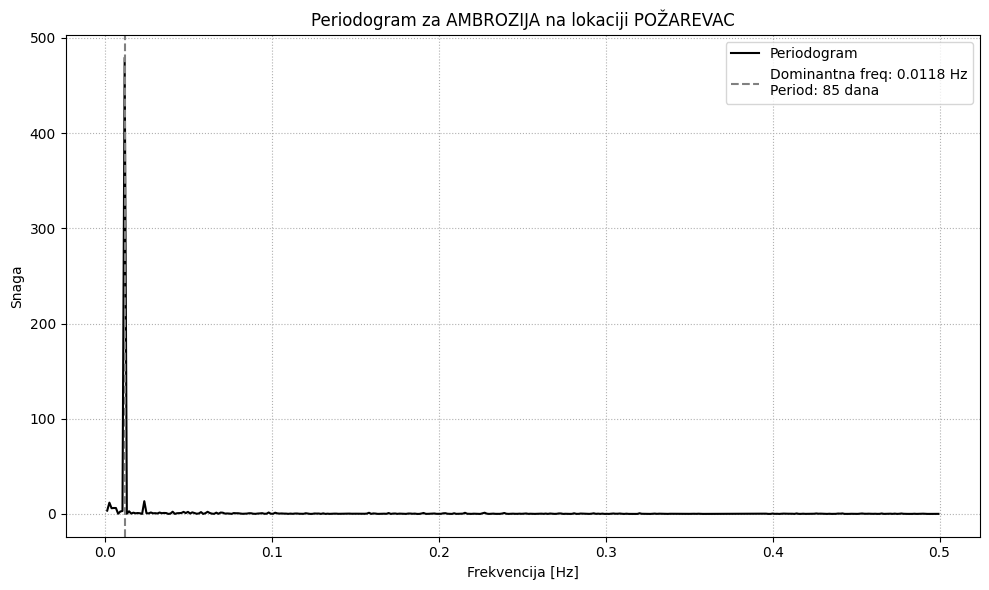

Dominantni period za AMBROZIJA (POŽAREVAC) je: 85 dana


In [53]:
dominant_period = plot_periodogram(data, save=False)

### Dodavanje egzogenih promenljivih

#### Dodavanje Furijeovih redova

In [ ]:
def generate_t(dates):
    """
    Generisanje linearne komponente niza
    """
    dates = pd.to_datetime(dates)
    df = pd.DataFrame({'date': dates})
    min_year = df['date'].dt.year.min()
    max_year = df['date'].dt.year.max()
    start_md = dates.apply(lambda x: (x.month, x.day)).min()
    end_md = dates.apply(lambda x: (x.month, x.day)).max()
    all_dates = []
    # Kreiranje kompletanog niza svih datuma u sezonama od min_year do max_year
    for year in range(min_year, max_year + 1):
        start_date =  pd.Timestamp(year=year, month=start_md[0], day=start_md[1])
        end_date = pd.Timestamp(year=year, month=end_md[0], day=end_md[1])
        season_dates = pd.date_range(start=start_date, end=end_date, freq='D')
        all_dates.extend(season_dates.tolist())
    
    # Mapiranje datum -> t
    t_map = {date: idx for idx, date in enumerate(all_dates)}
    t_list = [t_map.get(date, np.nan) for date in df['date']]
    
    return np.array(t_list)

data['t'] = generate_t(data['date'])

features_cols = []

def add_fourier_terms(df, col='t', period=dominant_period, K=3):
    for k in range(1, K+1):
        df[f'cos_{k}'] = np.cos(2 * np.pi * k * df[col] / period)
        df[f'sin_{k}'] = np.sin(2 * np.pi * k * df[col] / period)
        features_cols.extend([f'cos_{k}'])
        features_cols.extend([f'sin_{k}'])
    return df

data = add_fourier_terms(data, col='t', period=dominant_period, K=3)

#### Dodavanje meteoroloških parametara

In [55]:
exog_cols = ['temperature', 'humidity']

features = data[features_cols]
exog = data[features_cols + exog_cols]

## Test stacionarnosti

In [46]:
def stationarity_test(series, regression='c'):
    print("=== Augmented Dickey-Fuller (ADF) Test ===")
    adf_result = adfuller(series, regression=regression, autolag='AIC')
    adf_stat, adf_p = adf_result[0], adf_result[1]
    print(f"ADF Statistic: {adf_stat:.4f}")
    print(f"p-value: {adf_p:.4f}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"   {key}: {value:.4f}")
    print("=> ADF Null hypothesis: series is non-stationary")

    print("\n=== KPSS Test ===")
    kpss_result = kpss(series, regression=regression, nlags="auto")
    kpss_stat, kpss_p = kpss_result[0], kpss_result[1]
    print(f"KPSS Statistic: {kpss_stat:.4f}")
    print(f"p-value: {kpss_p:.4f}")
    print("Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"   {key}: {value:.4f}")
    print("=> KPSS Null hypothesis: series is stationary")

    print("\n=== Zaključak ===")
    if adf_p < 0.05 and kpss_p > 0.05:
        print("Serija je stacionarna (ADF odbacuje H0, KPSS prihvata H0).")
    elif adf_p > 0.05 and kpss_p < 0.05:
        print("Serija NIJE stacionarna (ADF prihvata H0, KPSS odbacuje H0).")
    else:
        print("Rezultati su neodlučni ili kontradiktorni. Razmisli o dodatnom razlikovanju (differencing) ili vizuelnoj analizi.")


stationarity_test(data['transform'])


=== Augmented Dickey-Fuller (ADF) Test ===
ADF Statistic: -7.0477
p-value: 0.0000
Critical Values:
   1%: -3.4392
   5%: -2.8654
   10%: -2.5688
=> ADF Null hypothesis: series is non-stationary

=== KPSS Test ===
KPSS Statistic: 0.1137
p-value: 0.1000
Critical Values:
   10%: 0.3470
   5%: 0.4630
   2.5%: 0.5740
   1%: 0.7390
=> KPSS Null hypothesis: series is stationary

=== Zaključak ===
Serija je stacionarna (ADF odbacuje H0, KPSS prihvata H0).


## Sezonska dekompozicija

Graf je sačuvan kao grafici\seasonal_segment_AMBROZIJA_POŽAREVAC.png


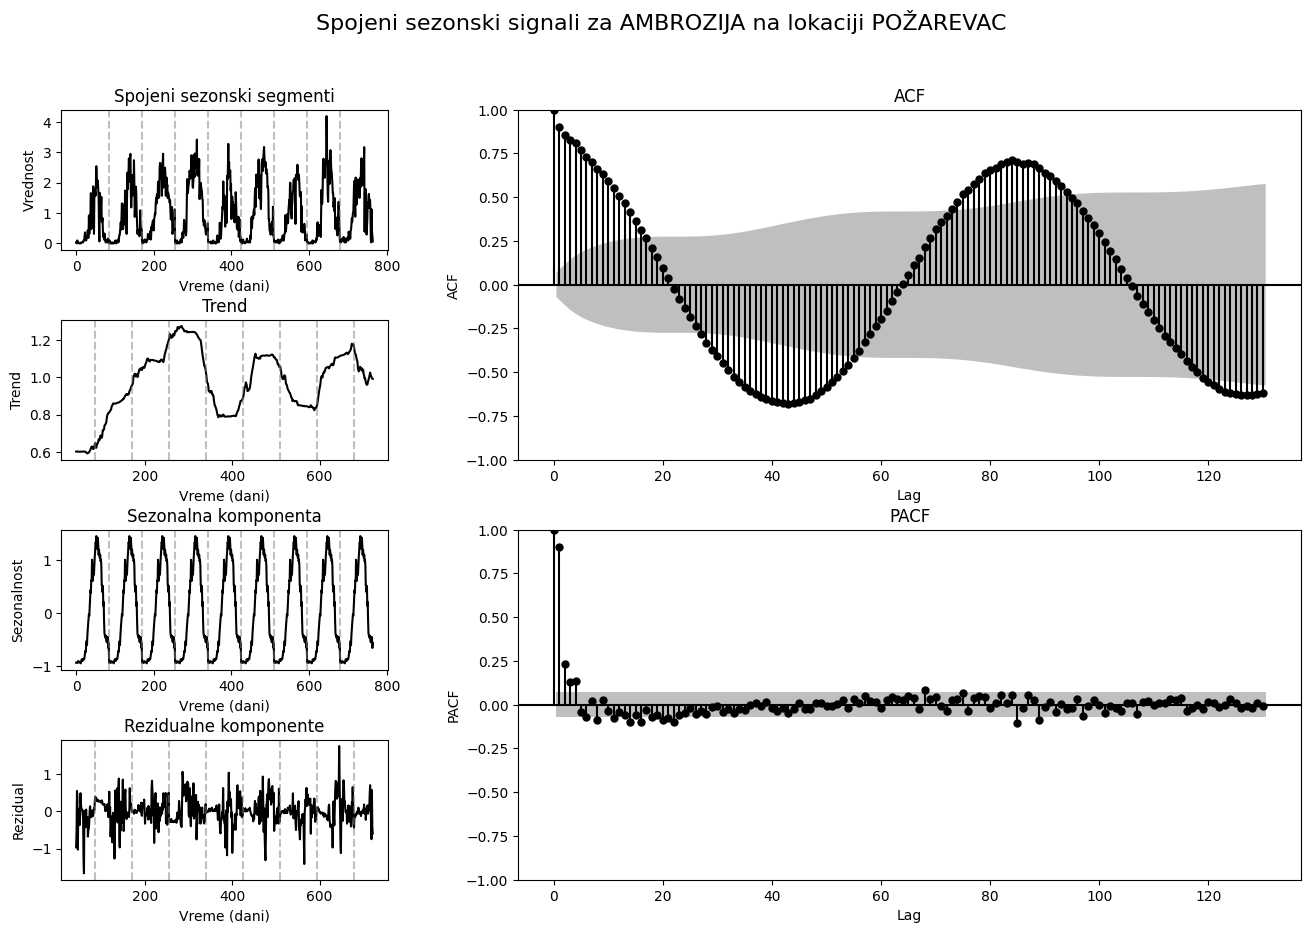

In [47]:
seasonal_segment_decomposition(data, allergen=allergen, location=location, column='transform', save=True)

## Određivanje optimalnih parametara SARIMAX modela pomoću GRID search

In [63]:
def sarima_model_selection(data, exog_cols, p_range=range(0, 3), d=0, q_range=range(0, 3),
                                    P_range=range(0, 2), D=0, Q_range=range(0, 2), s=dominant_period):
    """
    Grid search za optimizaciju SARIMA parametara: bira najbolji model po AICC.
    """
    results_log = []
    best_score = np.inf
    best_model = None
    best_params = None
    exog = data[exog_cols] if exog_cols else None

    # Grid search kroz sve kombinacije p, q, P, Q
    for p, q, P, Q in tqdm(itertools.product(p_range, q_range, P_range, Q_range)):
        try:
            # Treniranje SARIMAX modela za trenutnu kombinaciju parametara
            model = SARIMAX(data['transform'],
                            order=(p, d, q), 
                            seasonal_order=(P, D, Q, s), 
                            exog=exog, 
                            enforce_stationarity=False, 
                            enforce_invertibility=False)
            results = model.fit(disp=False)

            # Izračunavanje AIC, AICC i BIC metrika
            k = len(results.params)  
            n = len(data)
            aic = results.aic
            bic = results.bic
            aicc = aic + (2 * k * (k + 1)) / (n - k - 1)

            # Čuvanje rezultata u log
            results_log.append({
                'order': (p, d, q),
                'seasonal_order': (P, D, Q, s),
                'aic': aic,
                'aicc': aicc,
                'bic': bic
            })
            # Provera da li je trenutni model najbolji po AICC
            if aicc < best_score:
                best_score = aicc
                best_model = results
                best_params = {'order': (p, d, q), 'seasonal_order': (P, D, Q, s)}

        except Exception:
            print(f"Error: ({p},{q},{d}), ({P},{D},{Q},{s}))")
            continue
    # Čuvanje najboljeg modela i njegovih parametara
    results_df = pd.DataFrame(results_log)
    return best_model, best_params, best_score, results_df


# Pokretanje model selekcije na ucitanoj seriji
best_model, best_params, best_score, results_df = sarima_model_selection(data[data['date']<'2024-01-01'], exog_cols = features_cols + exog_cols )

print("\nNajbolji parametri:")
print(f"order: {best_params['order']}")
print(f"seasonal_order: {best_params['seasonal_order']}")
print("\nSummary najboljeg modela:\n")
print(best_model.summary())

36it [1:12:31, 120.88s/it]


Najbolji parametri:
order: (2, 0, 1)
seasonal_order: (1, 0, 0, 85)

Summary najboljeg modela:

                                      SARIMAX Results                                      
Dep. Variable:                           transform   No. Observations:                  680
Model:             SARIMAX(2, 0, 1)x(1, 0, [], 85)   Log Likelihood                -166.310
Date:                             Thu, 04 Sep 2025   AIC                            358.620
Time:                                     13:43:39   BIC                            415.628
Sample:                                          0   HQIC                           380.824
                                             - 680                                         
Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
cos_1   

## Rolling SARIMAX predikcija

In [ ]:
def rolling_sarimax_forecast(data, start_date, end_date, horizon=1, exog_cols=None,
                              order=(2, 0, 2), seasonal_order=(0, 0, 1, 85),
                              refit_every=35, lmbda=None):
    """
    Rolling forecast evaluacija modela za dat opseg datuma.
    """
    results = []
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    valid_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    model_fit = None
    count_since_refit = refit_every

    for current_date in tqdm(valid_dates, desc="Rolling forecast"):

        # Kreiranje trening skupa do trenutnog datuma
        train_df = data[data['date'] < current_date].copy()
        # Generisanje future DataFrame-a za predikciju
        future = pd.date_range(start=current_date, periods=horizon)
        future_df = pd.DataFrame({'date': future})
        future_df = pd.merge(future_df, data, on='date')

        # Inicijalizacija nizova za predikcije i intervale poverenja
        preds = np.zeros(horizon)
        lower_bounds = np.zeros(horizon)
        upper_bounds = np.zeros(horizon)

        exog_train = train_df[exog_cols].values if exog_cols else None

        if not future_df.empty:
            exog_future = future_df[exog_cols].values if exog_cols else None
            
            # Refit modela ako je potrebno
            if count_since_refit >= refit_every or model_fit is None:
                model = SARIMAX(
                    train_df["transform"],
                    order=order,
                    seasonal_order=seasonal_order,
                    exog=exog_train,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                model_fit = model.fit(disp=False)
                count_since_refit = 0

            # Generisanje predikcije i intervala poverenja
            forecast_res = model_fit.get_forecast(steps=len(future_df), exog=exog_future)
            forecast = forecast_res.predicted_mean
            conf_int = forecast_res.conf_int(alpha=0.05)

            for i, (_, row) in enumerate(future_df.iterrows()):
                idx = (row["date"] - current_date).days
                if 0 <= idx < horizon:
                    yhat = forecast.iloc[i]
                    lower = conf_int.iloc[i, 0]
                    upper = conf_int.iloc[i, 1]

                    if lmbda is not None:
                        preds[idx] = np.round(np.clip(inv_boxcox(yhat, lmbda) - 1e-1))
                        lower_bounds[idx] = np.clip(inv_boxcox(lower, lmbda)-1e-1, 0, None)
                        upper_bounds[idx] = np.clip(inv_boxcox(upper, lmbda)-1e-1, 0, None)
                    else:
                        preds[idx] = np.round(np.clip(30*np.expm1(yhat), 0, None), 0)
                        lower_bounds[idx] = np.clip( 30 * np.expm1(lower), 0, None)
                        upper_bounds[idx] = np.clip(30 * np.expm1(upper), 0, None)

        actual = data.loc[data['date'] == current_date, 'value']
        actual = actual.iloc[0] if not actual.empty else np.nan

        result_row = {
            "date": current_date,
            "actual": actual,
            "prediction": preds[0] if len(preds) > 0 else np.nan
        }

        for i in range(horizon):
            result_row[f"pred{i}d"] = preds[i]
            result_row[f"pred{i}d_lower"] = lower_bounds[i]
            result_row[f"pred{i}d_upper"] = upper_bounds[i]

        results.append(result_row)

        # Ažuriranje modela sa novim podacima bez refitovanja
        y_obs = data.loc[data["date"] == current_date, "transform"]
        x_obs = data.loc[data["date"] == current_date, exog_cols] if exog_cols else None
        if not y_obs.empty:
            model_fit = model_fit.append(
                endog=y_obs.values,
                exog=x_obs.values if exog_cols else None,
                refit=False
            )

        count_since_refit += 1

    return pd.DataFrame(results)

rolling_df = rolling_sarimax_forecast(
    data=data,
    exog_cols=features_cols + exog_cols,
    order=best_params['order'],
    seasonal_order=best_params['seasonal_order'],
    start_date='2024-07-09',
    end_date="2024-09-30",
    horizon=30,
    refit_every=7,
    lmbda=None
)

Rolling forecast: 100%|██████████| 84/84 [37:03<00:00, 26.47s/it]  


### Prikaz predikcije za sledeći dan

Graf je sačuvan kao grafici\AMBROZIJA_POŽAREVAC_seasonal_prediction_1d.png


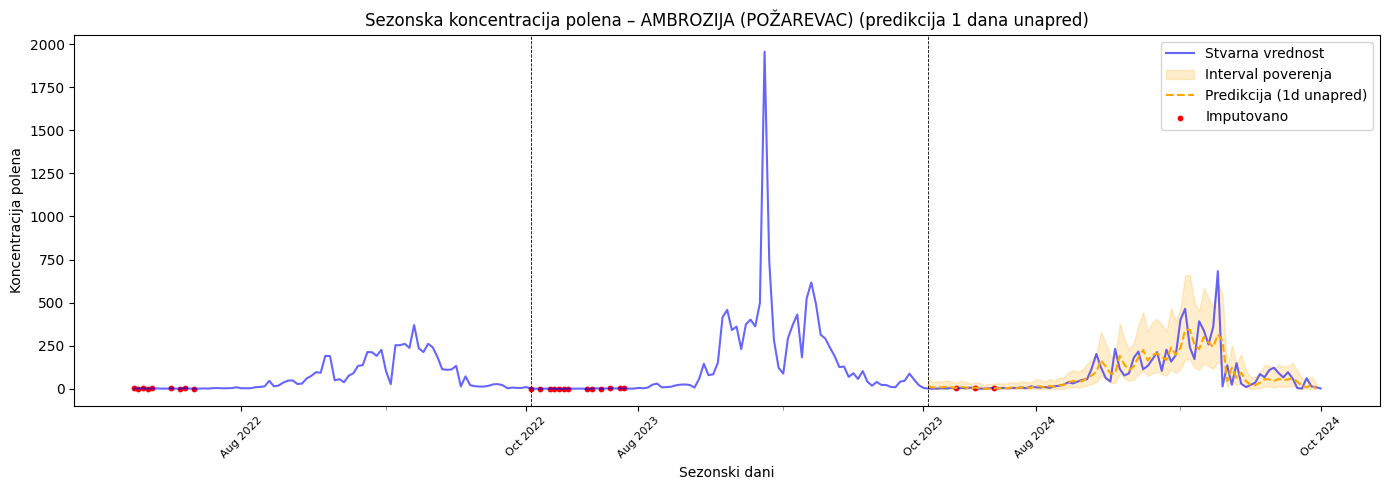

In [ ]:
plot_seasonal_predictions(data = data, 
                          forecast_df = rolling_df, 
                          allergen = allergen, 
                          location = location, 
                          n_seasons=3, 
                          n_days=1, 
                          col='value', 
                          save=True)

### Prikaz predikcije za 7. dan unapred

Graf je sačuvan kao grafici\AMBROZIJA_POŽAREVAC_seasonal_prediction_7d.png


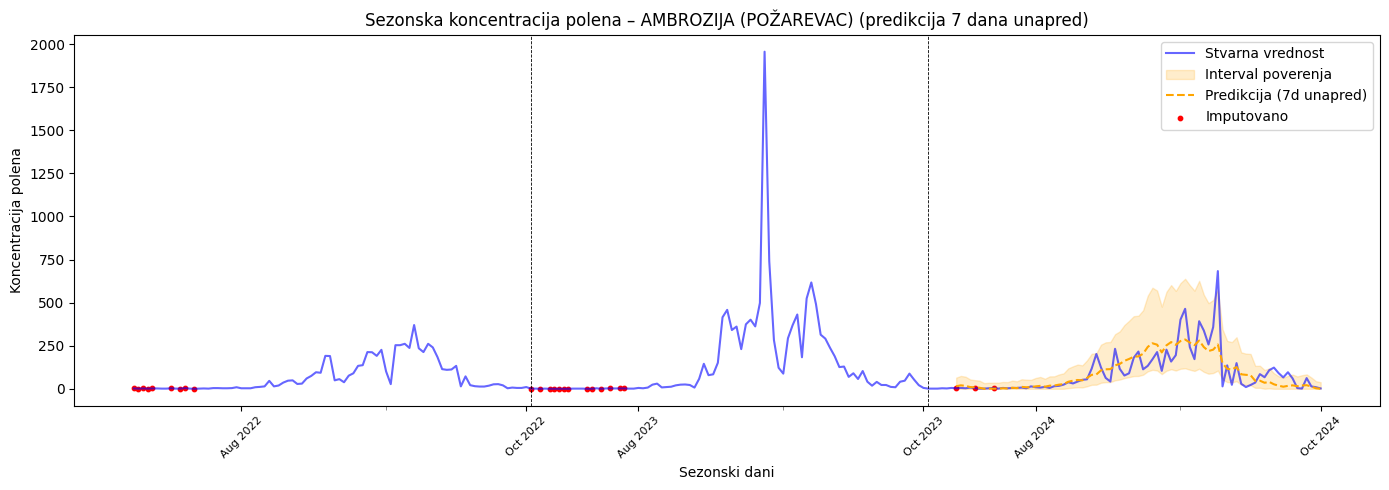

In [ ]:
plot_seasonal_predictions(data = data, 
                          forecast_df = rolling_df,
                          allergen = allergen, 
                          location = location, 
                          n_seasons=3, 
                          n_days=7, 
                          col='value', 
                          save=True)

### Prikaz predikcije 30 dana unapred

Graf je sačuvan kao grafici\AMBROZIJA_POŽAREVAC_seasonal_prediction_to_2024-09-13.png


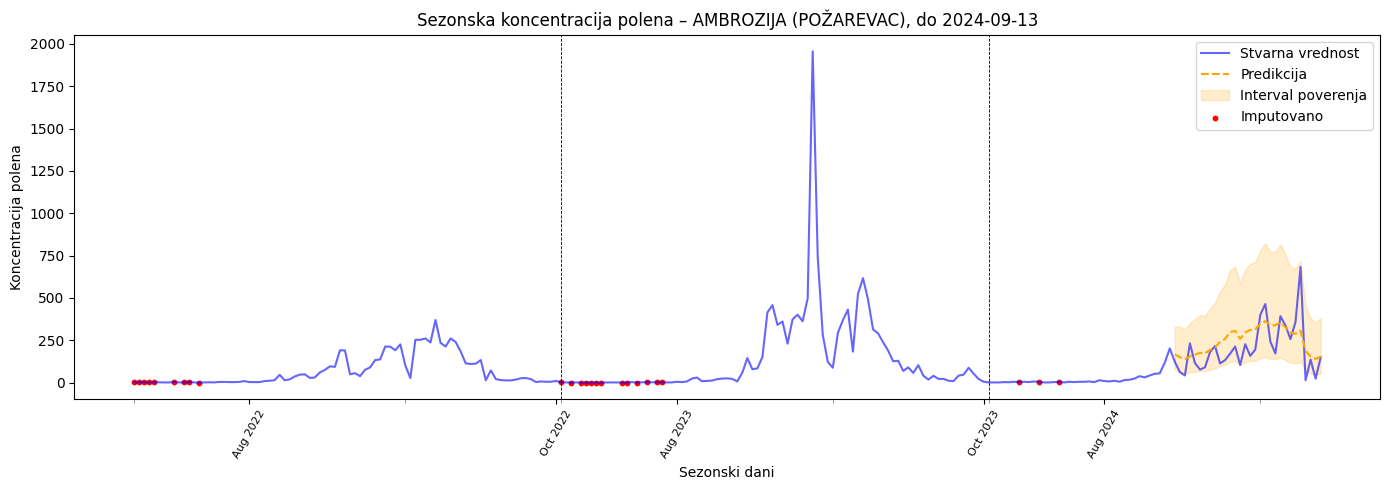

In [ ]:
plot_seasonal_predictions_limited(data = data, 
                                  forecast_df = rolling_df, 
                                  cutoff_date = '2024-08-15', 
                                  n_seasons=3, 
                                  col='value', 
                                  days_to_predict=30, 
                                  save=True)

### Evaluacija

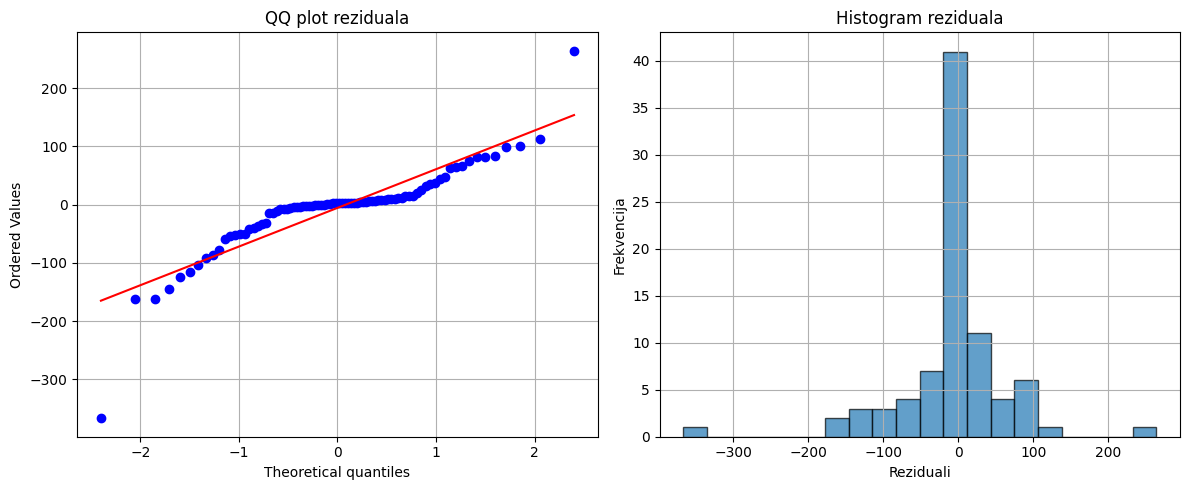


=== Ljung-Box test za autokorelaciju reziduala ===
Statistika: 48.9981
p-vrednost: 0.5136
Broj lagova: 50
=> H0: Nema autokorelacije u rezidualima
Ne odbacujemo H0: nema dokaza o autokorelaciji – reziduali su u redu.


,Vrednost
RMSE,72.614032
MAE,41.488095
RMSLE,0.423098
Bias (mean error),-5.750000
Correlation,0.810959


In [ ]:
evaluate_forecast_metrics(pred_df = rolling_df, 
                          allergen=allergen, 
                          location=location, 
                          lags=50, 
                          save=False)

### Metrike po danima

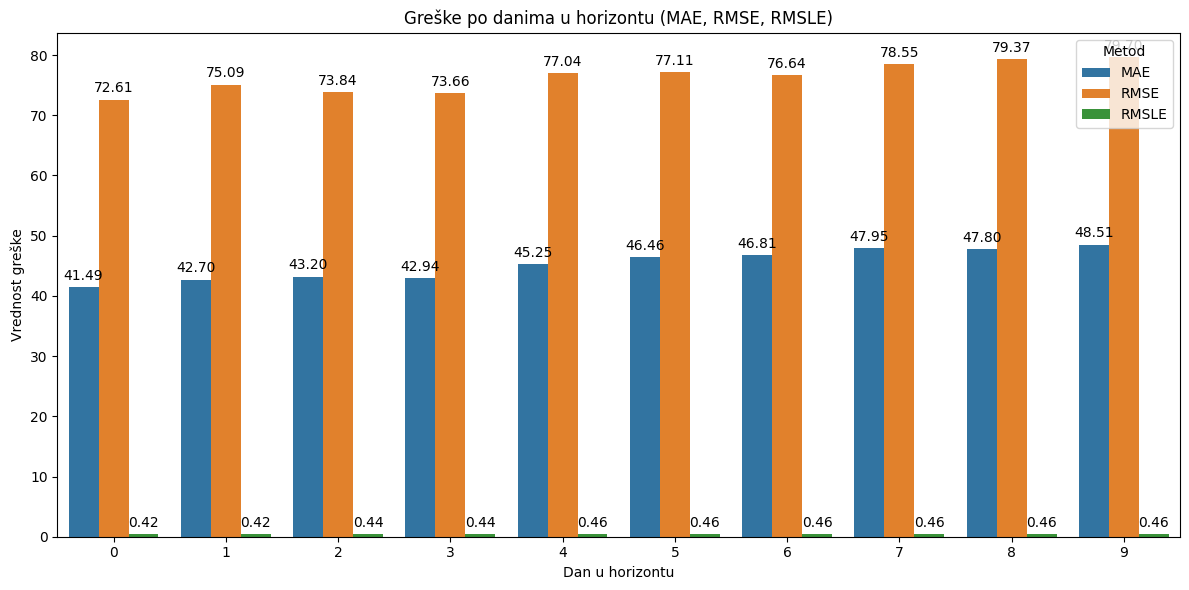

In [ ]:
plot_forecast_error_metrics_from_rolling(rolling_df = rolling_df, 
                                             allergen=allergen, 
                                             location=location, 
                                             horizon=10, 
                                             save=False)

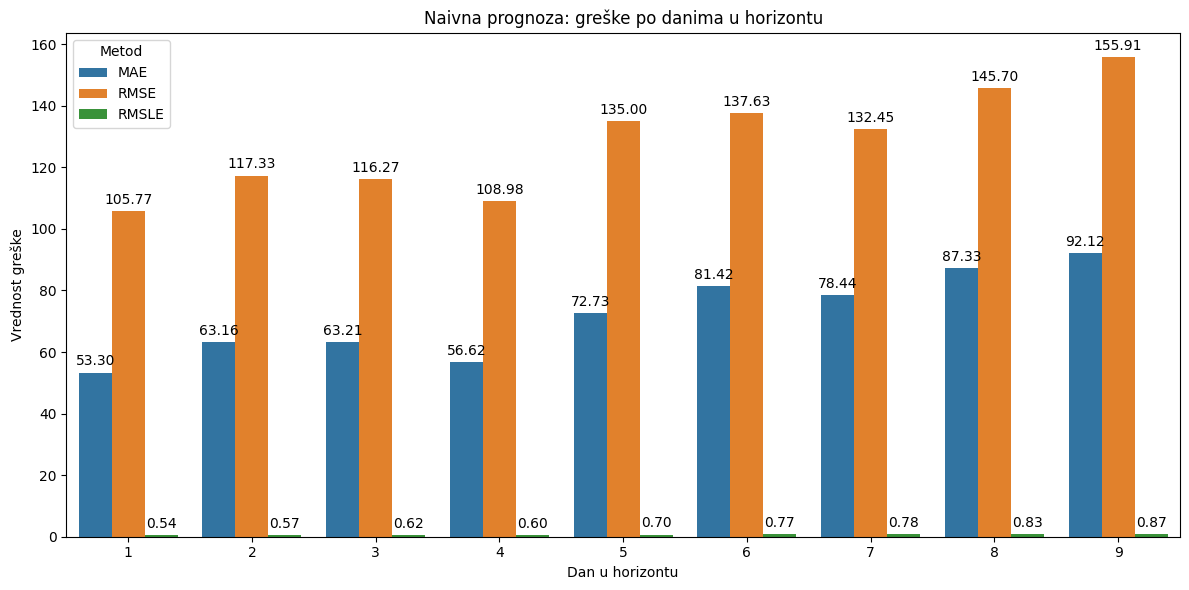

In [ ]:
plot_naive_forecast_metrics_from_rolling(rolling_df = rolling_df, 
                                         allergen=allergen, 
                                         location=location, 
                                         horizon=10, 
                                         save=False)


# Poredjenje više SARIMAX modela

In [2]:
class SarimaPipeline:
    """
    SarimaPipeline klasa za predikciju vremenskih serija polena koristeći:
    - log ili Box-Cox transformaciju,
    - Furijeovu komponente za sezonske obrasce,
    - SARIMA model sa opcionim egzogenim varijablama (npr. meteorološki podaci).
    """
    def __init__(self, transform=None, exog_cols=None, fourier_order=3, value_col="value", date_col="date"):

        assert transform in ['log', 'boxcox', None], "Transformacija mora biti 'log', 'boxcox' ili None."
        self.transform = transform
        self.exog_cols = exog_cols if exog_cols is not None else []  # meteo promenljive
        self.fourier_order = fourier_order # max Furijeov red
        self.value_col = value_col # naziv kolone za vrednost
        self.date_col = date_col # naziv vremenske kolone
        self.rolling_df = None # Evaluacija modela
        self.auto_res = None # Rezultati automatskog podešavanja
        self.fitted_model = None # Fitovani SARIMAX model
        self.summary_text = None # SARIMAX rezime po transformaciji
        self.rolling_dfs = None # Lista rezultata po transformaciji
        self.feature_importances = None # lista SARIMAX rezimea po transformaciji
        self.metrics_df = None # Objedinjene metrike performansi
        self.classification_results = None #Klasifikacija polena po nivoima

        self.order = (0,0,0)
        self.seasonal_order = (0,0,0,0)

    def _apply_transform(self, series):
        """
        Transformacija niz.
        """
        if self.transform == 'log':
            transformed = np.log1p(series/30)
            self.lmbda = None
        elif self.transform == 'boxcox':
            safe_val = series + 1e-1
            transformed, self.lmbda = boxcox(safe_val)
        else:  # None
            transformed = series
            self.lmbda = None
        return transformed

    def _inverse_transform(self, series):
        """
        Inverzna transformacija serije.
        """
        if self.transform == 'log':
            return 30 * np.expm1(series)
        elif self.transform == 'boxcox':
            return inv_boxcox(series, self.lmbda) - 1e-1
        return series

    def _get_period(self):
        """
        Detekcija dominantnog perioda u seriji pomoću periodograma.
        """
        # Dominantni period iz periodograma
        frequencies, power = periodogram(self.data['transform'])
        dominant_idx = np.argmax(power[1:]) + 1
        dominant_period = int(np.round(1 / frequencies[dominant_idx]))

        # Očekivani broj dana trajanja sezone
        start = pd.to_datetime(f'2024-{self.start_md[0]:02d}-{self.start_md[1]:02d}', format='%Y-%m-%d')
        end = pd.to_datetime(f'2024-{self.end_md[0]:02d}-{self.end_md[1]:02d}', format='%Y-%m-%d')

        expected_season_days = (end - start).days + 1

        tolerance = 10
        if abs(dominant_period - expected_season_days) > tolerance:
            dominant_period = expected_season_days

        return dominant_period

    def _get_md(self):
        """
        Detekcija početka i kraja sezone.
        """
        min_md = self.data[self.date_col].apply(lambda x: (x.month, x.day)).min()
        max_md = self.data[self.date_col].apply(lambda x: (x.month, x.day)).max()
        return min_md, max_md

    def _generate_t(self, dates):
        """
        Generinje linearne komponente
        """
        dates = pd.to_datetime(dates)
        df = pd.DataFrame({'date': dates})
        max_year = df['date'].dt.year.max()
        all_dates = []

        # Kreiranje kompletanog niza svih datuma u sezonama od min_year do max_year
        for year in range(self.min_year, max_year + 1):
            start_date =  pd.Timestamp(year=year, month=self.start_md[0], day=self.start_md[1])
            end_date = pd.Timestamp(year=year, month=self.end_md[0], day=self.end_md[1])
            season_dates = pd.date_range(start=start_date, end=end_date, freq='D')
            all_dates.extend(season_dates.tolist())
        
        # Mapiranje datum -> t
        t_map = {date: idx for idx, date in enumerate(all_dates)}
        t_list = [t_map.get(date, np.nan) for date in df['date']]
        
        return np.array(t_list)

    def _add_fourier_terms(self, K):
        """
        Dodavanje K Furijeovih komponenti kao egzogene promenljive.
        """
        self.data['t'] = self._generate_t(self.data[self.date_col])
        self.features_names = []

        for k in range(1, K + 1):
            cname = f'cos_{k}'
            sname = f'sin_{k}'
            valid_mask = self.data['t'].notna()

            # Izračunavanje cos i sin komponenti
            self.data.loc[valid_mask, cname] = np.cos(2 * np.pi * k * self.data.loc[valid_mask, 't'] / self.period)
            self.data.loc[valid_mask, sname] = np.sin(2 * np.pi * k * self.data.loc[valid_mask, 't'] / self.period)

            for name in [cname, sname]:
                if name not in self.features_names:
                    self.features_names.append(name)

    def _check_exog_cols(self, df):
        """
        Provera da li df sadrži sve exog kolone.
        """
        missing_cols = [col for col in self.exog_cols if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Nedostaju egzogene kolone u df: {missing_cols}")
        
    def _compute_fourier_for_dates(self, dates):
        """
        Generinje Furijeovih redova za listu datuma.
        """
        t = np.array(self._generate_t(dates))
        dct = {}
        dct = {self.date_col: dates}
        for k in range(1, self.fourier_order + 1):
            cos_k = np.full_like(t, np.nan, dtype=np.float64)
            sin_k = np.full_like(t, np.nan, dtype=np.float64)
            valid_mask = ~np.isnan(t)

            # Izračunavanje cos i sin komponenti
            cos_k[valid_mask] = np.cos(2 * np.pi * k * t[valid_mask] / self.period)
            sin_k[valid_mask] = np.sin(2 * np.pi * k * t[valid_mask] / self.period)

            dct[f'cos_{k}'] = cos_k
            dct[f'sin_{k}'] = sin_k

        return pd.DataFrame(dct)
        
    def _set_order(self, order=None, seasonal_order=None):
        """
        Postavljanje (p,d,q) i  (P,D,Q,s) parametre modela.
        """
        if order: self.order = order
        if seasonal_order: self.seasonal_order = seasonal_order

    def _get_next_valid_dates(self, n_days):
        """
        Vraca sledećih n_days validnih datuma od poslednjeg definisanog datuma.
        """
        last_date = self.data[self.date_col].max()
        found = []
        candidate = last_date + pd.Timedelta(days=1)
        while len(found) < n_days:
            md = (candidate.month, candidate.day)
            if self.start_md <= md < self.end_md:
                found.append(candidate)
            candidate += pd.Timedelta(days=1)
        return found

    def _get_valid_dates(self, start_date, end_date):
        """
        Pronalazi sve datume izmedju start_date i end_date koji su u sezoni.
        """
        all_dates = pd.date_range(start=start_date, end=end_date)
        valid_dates = [d for d in all_dates if self.start_md <= (d.month, d.day) < self.end_md]
        return valid_dates

    def _preprocess(self, df):
        """
        Predprocesiranje ulaznog DataFrame-a pre treniranja modela.
        """
        # Provera prisustva svih egzogenih kolona
        self._check_exog_cols(df)

        # Kreiranje kopije ulaznih podataka
        self.data = df.copy()

        # Transformacija target kolone
        self.data['transform'] = self._apply_transform(self.data[self.value_col])

        # Detekcija minimalne godine u podacima (za generisanje t)
        self.min_year = self.data[self.date_col].dt.year.min()

        # Detekcija početnog i krajnjeg meseca/dana u sezoni
        self.start_md, self.end_md = self._get_md()

        # Detekcija dominantnog perioda serije pomoću periodograma
        self.period = self._get_period()

        # Generisanje fourier komponenti za sezonske obrasce
        self._add_fourier_terms(self.fourier_order)

    def fit(self, df, order=None, seasonal_order=None, preprocessed = False, previous_model = None):
        """
        Fitovanje SARIMA model sa prosleđenim parametrima.
        """
        if not preprocessed:
            self._preprocess(df)
            self._set_order(order, seasonal_order)
            endog = self.data['transform']
            exog = self.data[self.features_names+self.exog_cols] if self.features_names+self.exog_cols else None
        else:
            endog = df['transform']
            exog = df[self.features_names+self.exog_cols] if self.features_names+self.exog_cols else None

        # Ako se koristi prethodni fitovani model, uzimamo njegove koeficijente
        if previous_model:
            init_params = self.fitted_model.params
        else:
            init_params = None

        # Inicijalizacija modela
        model = SARIMAX(endog, exog=exog, order=self.order, seasonal_order=self.seasonal_order, enforce_invertibility=False, enforce_stationarity=False, start_params=init_params)
        self.fitted_model = model.fit(disp=False)

        self.summary_text = self.fitted_model.summary().as_text()
        return self.fitted_model
        
    def forecast(self, days=1, exog_df=None):
        """
        Predviđa vrednosti za narednih `days` dana.
        """
        # Generisanje sledećih validnih datuma za predikciju
        forecast_dates = self._get_next_valid_dates(n_days=days)
        exog_future = pd.DataFrame({self.date_col: forecast_dates})

        # Generisanje Furijeovih redova za forecast datume
        if self.fourier_order != 0:
            exog_future = self._compute_fourier_for_dates(forecast_dates)

        # Priprema egzogenih promenljivih ako su definisane
        if self.exog_cols:
            if exog_df is not None:
                self._check_exog_cols(exog_df)
                exog_future = pd.merge(exog_future, exog_df, on=self.date_col, how="left")
            else:
                raise ValueError("exog_df mora biti prosleđen jer su exog_cols definisane.")
        exog_future = exog_future[self.features_names + self.exog_cols] if self.features_names + self.exog_cols else None
        # Predikcija korišćenjem treniranog SARIMA modela
        preds = self.fitted_model.forecast(steps=days, exog=exog_future)
        preds_orig = self._inverse_transform(preds)
        return pd.Series(preds_orig, index=forecast_dates, name='prediction')

    def auto_arima(self, data, end_date=pd.to_datetime('2023-12-31'),
                p_range=range(0, 5), d=0, q_range=range(0, 5),
                P_range=range(0, 2), D=0, Q_range=range(0, 2),
                transforms=None, fourier_orders=None,
                n_combinations=48):
        """
        Nasumična pretraga SARIMA (+Fourier + transformacija) parametara: bira najbolji model po AICC.
        """
        if fourier_orders is None:
            fourier_orders = [self.fourier_order]

        if transforms is None:
            transforms = [self.transform]

        data_origin = data.copy()
        data = data[data[self.date_col] <= end_date]

        results_log = []
        best_score = np.inf
        best_model = None
        best_params = None

        # Kombinacije SARIMA + Fourier parametara
        base_combinations = list(itertools.product(p_range, q_range, P_range, Q_range))
        valid_combinations = [(p, q, P, Q) for (p, q, P, Q) in base_combinations
                            if not ((P >= 1 or Q >= 1) and (p > 2 or q > 2))]
        all_combinations = list(itertools.product(valid_combinations, fourier_orders))
        sampled_combinations = random.sample(all_combinations, min(n_combinations, len(all_combinations)))

        for (p, q, P, Q), fourier_order in tqdm(sampled_combinations, desc="Grid Search"):
            for transform in transforms:
                try:
                    self.transform = transform
                    self.fourier_order = fourier_order

                    self._preprocess(data)
                    s = self.period
                    self._set_order(order=(p, d, q), seasonal_order=(P, D, Q, s))

                    results = self.fit(data)

                    k = len(results.params)
                    n = len(data)
                    if n <= k + 1:
                        continue  # skip nevalidne kombinacije

                    aic = results.aic
                    aicc = aic + (2 * k * (k + 1)) / (n - k - 1)
                    bic = results.bic

                    results_log.append({
                        'order': (p, d, q),
                        'seasonal_order': (P, D, Q, s),
                        'fourier_order': fourier_order,
                        'transform': transform,
                        'aic': aic,
                        'aicc': aicc,
                        'bic': bic
                    })

                    if aicc < best_score:
                        best_score = aicc
                        best_model = results
                        best_params = {
                            'order': (p, d, q),
                            'seasonal_order': (P, D, Q, s),
                            'fourier_order': fourier_order,
                            'transform': transform
                        }
                except Exception as e:
                    print(f"Greška za kombinaciju {(p,d,q),(P,D,Q)} | Fourier: {fourier_order} | Transform: {transform} → {e}")
                    continue

        results_df = pd.DataFrame(results_log)

        if best_model is not None:
            self.fitted_model = best_model
            self._set_order(order=best_params['order'], seasonal_order=best_params['seasonal_order'])
            self.fourier_order = best_params['fourier_order']
            self.transform = best_params['transform']

        self._preprocess(data_origin)
        self.auto_res = results_df
        return results_df

    def evaluate_model(self, start_date, end_date, horizon=30, refit_every=15, low=30, high=100):
        """
        Evaluacija najboljih modela po transformaciji iz auto_arima.
        Radi rolling forecast, računa regresione i klasifikacione metrike.
        """

        if self.auto_res is None or self.auto_res.empty:
            raise ValueError("Nema rezultata iz auto_arima. Pokreni auto_arima() pre evaluate_model().")

        data = self.data.copy()

        self.rolling_dfs = {}      
        self.summary_texts = {}     
        self.metrics_dfs = {}      
        classification_results = {}

        for transform in np.unique(self.auto_res['transform']):
            subset = self.auto_res[self.auto_res['transform'] == transform]
            best_row = subset.loc[subset['aicc'].idxmin()]

            self.transform = best_row['transform']
            self.fourier_order = best_row['fourier_order']
            self._set_order(order=best_row['order'], seasonal_order=best_row['seasonal_order'])

            self._preprocess(data)
            rolling_df = self.rolling_forecast(start_date, end_date, horizon=horizon, refit_every=refit_every)

            self.rolling_dfs[transform] = rolling_df
            self.summary_texts[transform] = self.fitted_model.summary().as_text()

            all_metrics = []
            transform_class_results = {}

            for i in range(horizon):
                col_pred = f"pred{i}d"
                col_actual = f"actual{i}d"
                rolling_df[col_actual] = rolling_df["actual"].shift(-i)

                actual = rolling_df[col_actual]
                pred = rolling_df[col_pred]
                mask = actual.notna() & pred.notna()

                if mask.sum() == 0:
                    continue

                # Regresione metrike
                all_metrics.append({
                    "transform": transform,
                    "forecast_day": i,
                    "MAE": np.mean(np.abs(pred[mask] - actual[mask])),
                    "RMSE": np.sqrt(np.mean((pred[mask] - actual[mask]) ** 2)),
                    "RMSLE": np.sqrt(np.mean((np.log1p(pred[mask] / 30) - np.log1p(actual[mask] / 30)) ** 2))
                })

                # Klasifikacija
                def classify(x):
                    if x < low:
                        return 'low'
                    elif x < high:
                        return 'moderate'
                    else:
                        return 'high'

                actual_cls = actual[mask].apply(classify)
                pred_cls = pred[mask].apply(classify)

                labels = ['low', 'moderate', 'high']
                cm = confusion_matrix(actual_cls, pred_cls, labels=labels)
                report = classification_report(actual_cls, pred_cls, labels=labels, output_dict=True)

                transform_class_results[i] = {
                    "confusion_matrix": cm,
                    "classification_report": report
                }

            self.metrics_dfs[transform] = pd.DataFrame(all_metrics)
            classification_results[transform] = transform_class_results

        self.classification_results = classification_results

        return self.metrics_dfs, self.rolling_dfs, self.summary_texts

    def rolling_forecast(self, start_date, end_date, horizon=1, refit_every=15):
        """
        Rolling forecast evaluacija modela za dat opseg datuma.
        """
        results = []
        data = self.data.copy()
        valid_dates = self._get_valid_dates(start_date, end_date)
        model_fit = None
        count_since_refit = refit_every

        for current_date in tqdm(valid_dates, desc="Rolling forecast"):
            # Kreiranje trening skupa do trenutnog datuma
            train_df = data[data[self.date_col] < current_date].copy()
            # Generisanje future DataFrame-a za predikciju
            future = pd.date_range(start=current_date, periods=horizon)
            future_df = pd.DataFrame({self.date_col: future})
            future_df = pd.merge(future_df, data, on=self.date_col)

            # Inicijalizacija nizova za predikcije i intervale poverenja
            preds = np.zeros(horizon)
            lower_bounds = np.zeros(horizon)
            upper_bounds = np.zeros(horizon)

            if not future_df.empty:
                exog_future_vals = future_df[self.features_names + self.exog_cols] if self.features_names + self.exog_cols else []
                # Refit modela ako je potrebno
                if count_since_refit >= refit_every or model_fit is None:
                    model_fit = self.fit(train_df, preprocessed=True, previous_model=model_fit)
                    count_since_refit = 0

                # Generisanje predikcije i intervala poverenja
                forecast_res = model_fit.get_forecast(steps=len(future_df), exog=exog_future_vals)
                forecast = forecast_res.predicted_mean
                conf_int = forecast_res.conf_int(alpha=0.05)

                for i, (_, row) in enumerate(future_df.iterrows()):
                    idx = (row[self.date_col] - current_date).days
                    if 0 <= idx < horizon:
                        yhat = forecast.iloc[i]
                        lower = conf_int.iloc[i, 0]
                        upper = conf_int.iloc[i, 1]
                        preds[idx] = max(0, round(self._inverse_transform(yhat)))
                        lower_bounds[idx] = max(0, round(self._inverse_transform(lower)))
                        upper_bounds[idx] = max(0, round(self._inverse_transform(upper)))

            actual = data.loc[data[self.date_col] == current_date, self.value_col]
            actual = actual.iloc[0] if not actual.empty else np.nan

            result_row = {
                "date": current_date,
                "actual": actual,
                "prediction": preds[0] if len(preds) > 0 else np.nan
            }
            for i in range(horizon):
                result_row[f"pred{i}d"] = preds[i]
                result_row[f"pred{i}d_lower"] = lower_bounds[i]
                result_row[f"pred{i}d_upper"] = upper_bounds[i]
            results.append(result_row)

            # Ažuriranje modela sa novim podacima bez refitovanja
            y_obs = data.loc[data[self.date_col] == current_date, "transform"]
            x_obs_cols = self.features_names + self.exog_cols
            x_obs = data.loc[data[self.date_col] == current_date, x_obs_cols] if x_obs_cols else None

            if not y_obs.empty:
                model_fit = model_fit.append(
                    endog=y_obs.values,
                    exog=x_obs.values if x_obs_cols else None,
                    refit=False
                )
            count_since_refit += 1
        self.rolling_df = pd.DataFrame(results)
        return self.rolling_df

## Najbolji modeli sa i bez meteo podataka, za boxcox i log transoformaciju

In [3]:
allergen = 'AMBROZIJA'
location = 'POŽAREVAC'

model_path = f"models/sarimax/{allergen}_{location}.pkl"
with open(model_path, 'rb') as f:
    loaded_model_meteo = pickle.load(f)

model_path = f"models/sarimax/{allergen}_{location}_nometeo.pkl"
with open(model_path, 'rb') as f:
    loaded_model_nometeo = pickle.load(f)

In [5]:
print("Najbolji modeli sa meteo kovarijatama (po AICc) ")
print(loaded_model_meteo.auto_res.groupby("transform").apply(lambda x: x.loc[x["aicc"].idxmin()]).to_string(index=False))

print("\nNajbolji modeli bez meteo kovarijata (po AICc) ")
print(loaded_model_nometeo.auto_res.groupby("transform").apply(lambda x: x.loc[x["aicc"].idxmin()]).to_string(index=False))


Najbolji modeli sa meteo kovarijatama (po AICc) 
    order seasonal_order  fourier_order transform         aic        aicc         bic
(2, 0, 1)  (1, 0, 1, 85)              3    boxcox 1801.264410 1801.895989 1862.657132
(2, 0, 1)  (1, 0, 1, 85)              3       log  361.559987  362.191566  422.952709

Najbolji modeli bez meteo kovarijata (po AICc) 
    order seasonal_order  fourier_order transform         aic        aicc         bic
(2, 0, 2)  (1, 0, 1, 85)              3    boxcox 1805.445473 1805.992019 1862.431059
(2, 0, 2)  (1, 0, 0, 85)              3       log  388.698167  389.165934  441.320500


In [17]:
print("Najbolji modeli sa meteo kovarijatama (po AICc) ")
print(loaded_model_meteo.auto_res.groupby("transform").apply(lambda x: x.loc[x["aicc"].idxmin()]).to_string(index=False))

print("\nNajbolji modeli bez meteo kovarijata (po AICc) ")
print(loaded_model_nometeo.auto_res.groupby("transform").apply(lambda x: x.loc[x["aicc"].idxmin()]).to_string(index=False))


Najbolji modeli sa meteo kovarijatama (po AICc) 
    order seasonal_order  fourier_order transform         aic        aicc         bic
(2, 0, 1)  (1, 0, 1, 85)              3    boxcox 1801.264410 1801.895989 1862.657132
(2, 0, 1)  (1, 0, 1, 85)              3       log  361.559987  362.191566  422.952709

Najbolji modeli bez meteo kovarijata (po AICc) 
    order seasonal_order  fourier_order transform         aic        aicc         bic
(2, 0, 2)  (1, 0, 1, 85)              3    boxcox 1805.445473 1805.992019 1862.431059
(2, 0, 2)  (1, 0, 0, 85)              3       log  388.698167  389.165934  441.320500


In [18]:
print("\nNajbolji modeli SA meteo (po RMSLE)")
print("Log:")
print(
    loaded_model_meteo.metrics_dfs['log']
    .nsmallest(1, 'RMSLE')[["RMSLE", "RMSE", "MAE"]]
    .to_string(index=False)
)

print("BoxCox:")
print(
    loaded_model_meteo.metrics_dfs['boxcox']
    .nsmallest(1, 'RMSLE')[["RMSLE", "RMSE", "MAE"]]
    .to_string(index=False)
)

print("\nNajbolji modeli BEZ meteo (po RMSLE) ")
print("Log:")
print(
    loaded_model_nometeo.metrics_dfs['log']
    .nsmallest(1, 'RMSLE')[["RMSLE", "RMSE", "MAE"]]
    .to_string(index=False)
)

print("BoxCox:")
print(
    loaded_model_nometeo.metrics_dfs['boxcox']
    .nsmallest(1, 'RMSLE')[["RMSLE", "RMSE", "MAE"]]
    .to_string(index=False)
)



Najbolji modeli SA meteo (po RMSLE)
Log:
   RMSLE     RMSE       MAE
0.421787 72.60526 41.571429
BoxCox:
   RMSLE      RMSE       MAE
0.430834 74.423898 43.488095

Najbolji modeli BEZ meteo (po RMSLE) 
Log:
   RMSLE      RMSE       MAE
0.447322 81.458944 43.654762
BoxCox:
   RMSLE      RMSE       MAE
0.478794 86.158906 47.238095


### RMSLE za naredih 7 dana

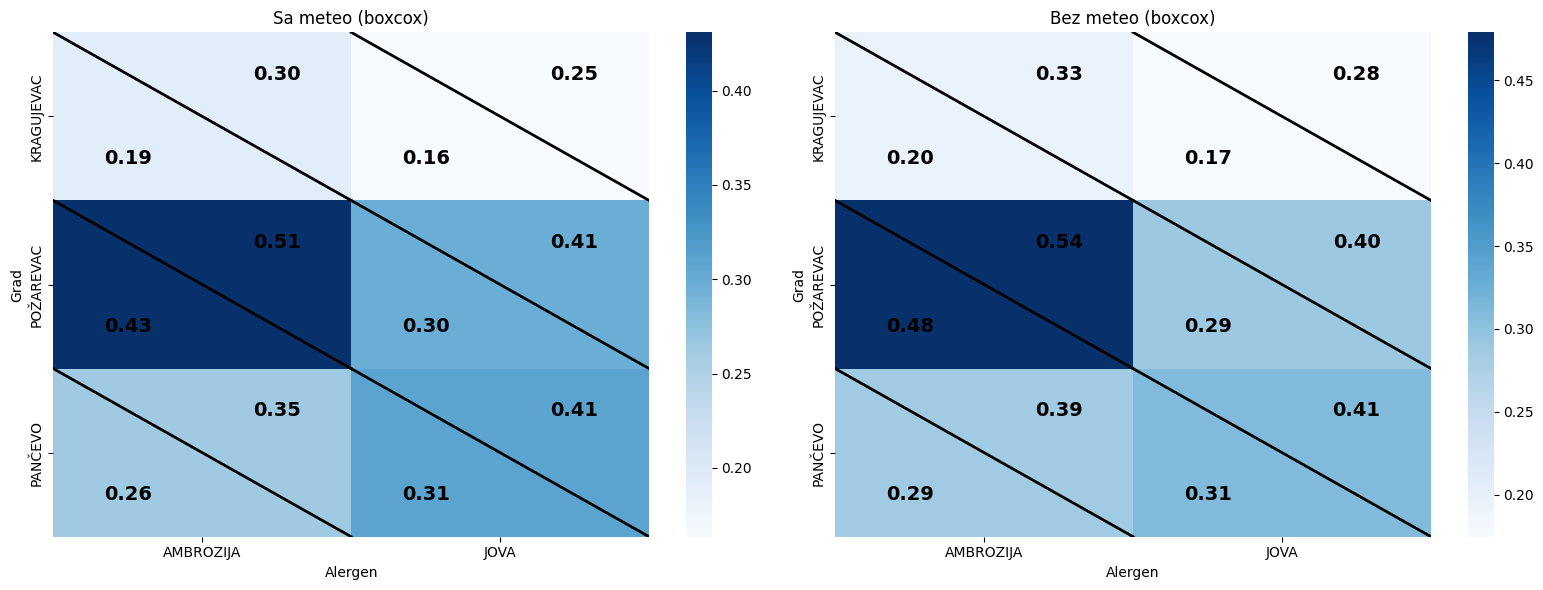

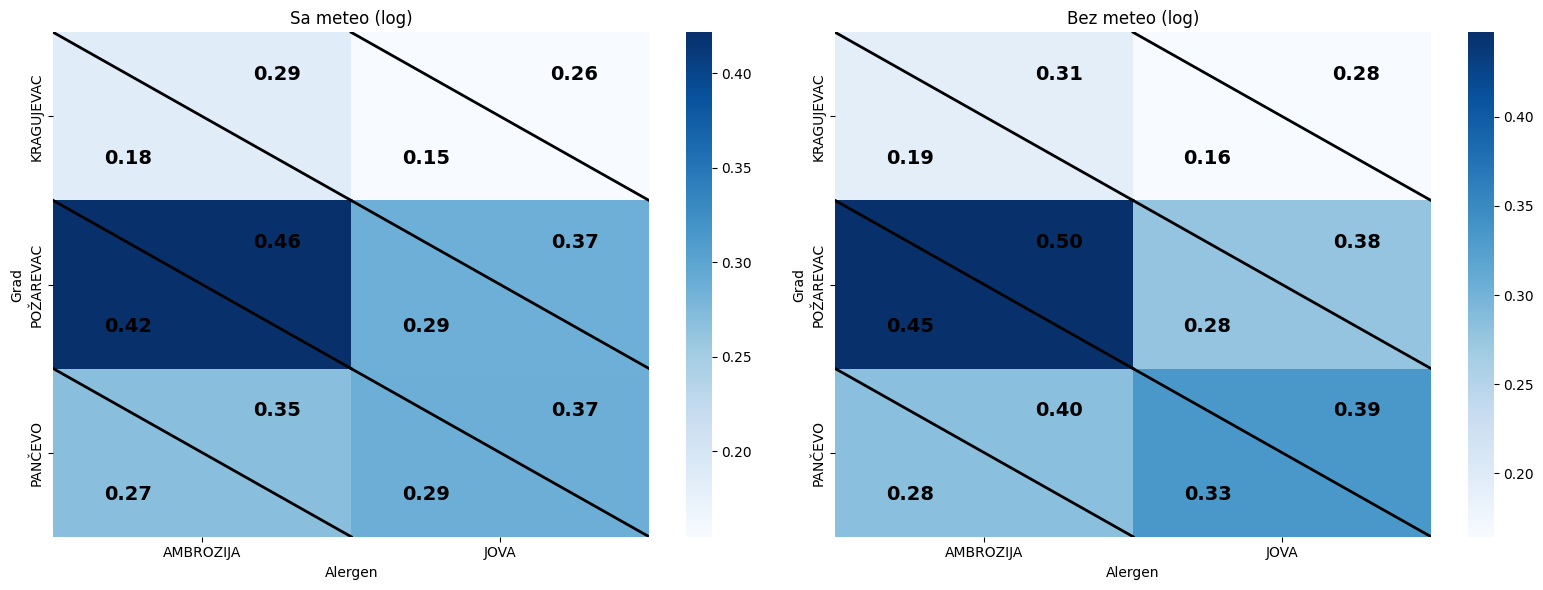

In [19]:
locations = ["KRAGUJEVAC", "POŽAREVAC", "PANČEVO"]
allergens = ["AMBROZIJA", "JOVA"]

# Funkcija za kreiranje RMSLE DataFrame-a za zadatu transformaciju
def get_rmsle_df_transform(transform_type='log', with_meteo=True):
    rmsle_df_list = []
    for location in locations:
        for allergen in allergens:
            if with_meteo:
                model_path = f"models/sarimax/{allergen}_{location}.pkl"
            else:
                model_path = f"models/sarimax/{allergen}_{location}_nometeo.pkl"
            with open(model_path, 'rb') as f:
                loaded_model = pickle.load(f)
            
            metrics_df = loaded_model.metrics_dfs[transform_type.lower()]
            
            rmsle_day_0 = metrics_df[metrics_df['forecast_day'] == 0]['RMSLE'].values[0]
            rmsle_day_6 = metrics_df[metrics_df['forecast_day'] == 6]['RMSLE'].values[0]
            
            rmsle_df_list.append([location, allergen, rmsle_day_0, rmsle_day_6])
    
    return pd.DataFrame(rmsle_df_list, columns=['Grad', 'Alergen', 'RMSLE_Day_0', 'RMSLE_Day_6'])

# Kreiranje DataFrame-ova za obe transformacije i sa/bez meteo
rmsle_df_log_meteo = get_rmsle_df_transform('log', with_meteo=True)
rmsle_df_log_nometeo = get_rmsle_df_transform('log', with_meteo=False)

rmsle_df_bc_meteo = get_rmsle_df_transform('boxcox', with_meteo=True)
rmsle_df_bc_nometeo = get_rmsle_df_transform('boxcox', with_meteo=False)

def plot_heatmap_two_subplots(rmsle_meteo, rmsle_nometeo, title):
    pivot_meteo = rmsle_meteo.pivot(index="Grad", columns="Alergen", values="RMSLE_Day_0").reindex(locations)
    pivot_nometeo = rmsle_nometeo.pivot(index="Grad", columns="Alergen", values="RMSLE_Day_0").reindex(locations)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Heatmap sa meteo
    sns.heatmap(pivot_meteo, annot=False, cmap="Blues", ax=axes[0])
    axes[0].set_title(f"Sa meteo ({title})")
    for i, row in enumerate(rmsle_meteo.itertuples()):
        row_idx = locations.index(row.Grad)
        col_idx = allergens.index(row.Alergen)
        x, y = col_idx + 0.5, row_idx + 0.5
        axes[0].plot([x - 0.5, x + 0.5], [y - 0.5, y + 0.5], color='black', lw=2)
        axes[0].text(x - 0.25, y + 0.25, f"{row.RMSLE_Day_0:.2f}", ha='center', va='center', fontsize=14, color='black', fontweight='bold')
        axes[0].text(x + 0.25, y - 0.25, f"{row.RMSLE_Day_6:.2f}", ha='center', va='center', fontsize=14, color='black', fontweight='bold')

    # Heatmap bez meteo
    sns.heatmap(pivot_nometeo, annot=False, cmap="Blues", ax=axes[1])
    axes[1].set_title(f"Bez meteo ({title})")
    for i, row in enumerate(rmsle_nometeo.itertuples()):
        row_idx = locations.index(row.Grad)
        col_idx = allergens.index(row.Alergen)
        x, y = col_idx + 0.5, row_idx + 0.5
        axes[1].plot([x - 0.5, x + 0.5], [y - 0.5, y + 0.5], color='black', lw=2)
        axes[1].text(x - 0.25, y + 0.25, f"{row.RMSLE_Day_0:.2f}", ha='center', va='center', fontsize=14, color='black', fontweight='bold')
        axes[1].text(x + 0.25, y - 0.25, f"{row.RMSLE_Day_6:.2f}", ha='center', va='center', fontsize=14, color='black', fontweight='bold')

    plt.tight_layout()

plot_heatmap_two_subplots(rmsle_df_bc_meteo, rmsle_df_bc_nometeo, "boxcox")

plot_heatmap_two_subplots(rmsle_df_log_meteo, rmsle_df_log_nometeo, "log")


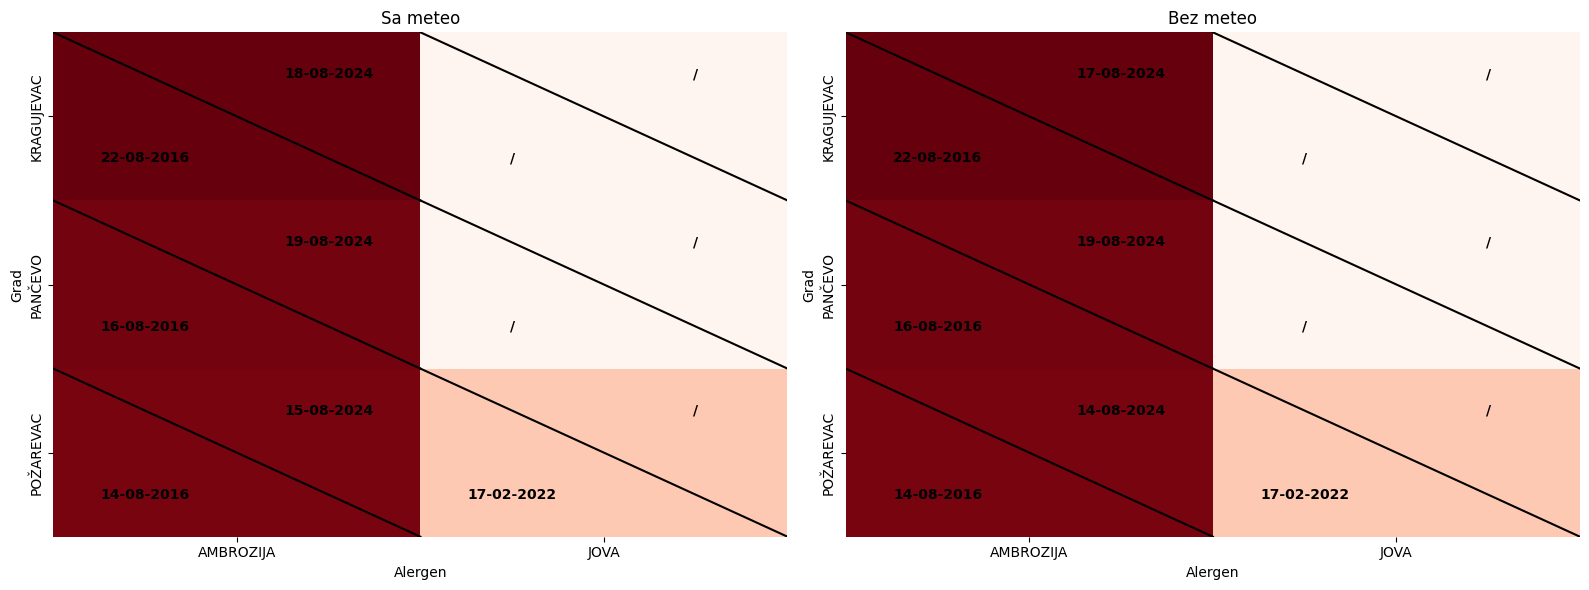

In [20]:
locations = ["KRAGUJEVAC", "POŽAREVAC", "PANČEVO"]
allergens = ["AMBROZIJA", "JOVA"]

thresholds = {
    'AMBROZIJA': 30,
    'JOVA': 60
}

def first_3days_above_threshold(df, allergen, value_col='value', add_days=0):
    df = df.copy()
    threshold = thresholds[allergen]
    df['above_threshold'] = df[value_col] > threshold
    df['three_days'] = df['above_threshold'].rolling(3).sum() == 3
    if df['three_days'].any():
        first_idx = df[df['three_days']].index[0]
        first_date = df.loc[first_idx - 2, 'date']
        return first_date + pd.Timedelta(days=add_days)
    else:
        return pd.NaT
    
def first_3days_above_threshold_pred(df, allergen, add_days=7):
    threshold = thresholds[allergen]
    value_cols = [f'pred{add_days-1}d', f'pred{add_days}d', f'pred{add_days+1}d']
    df['above_threshold'] = df[value_cols].gt(threshold).all(axis=1)
    if df['above_threshold'].any(): 
        first_idx = df[df['above_threshold']].index[0]
        first_date = df.loc[first_idx, 'date']
        return first_date + pd.Timedelta(days=add_days) 
    else:
        return pd.NaT 

def create_concentration_dates_df(loaded_models, forecast_days=7, with_meteo=True):
    results_list = []
    for location in locations:
        for allergen in allergens:
            key = f"{allergen}_{location}" + ("" if with_meteo else "_nometeo")
            model = loaded_models[key]

            # Stvarna vrednost
            actual_date = first_3days_above_threshold(model.data, allergen, value_col='value', add_days=0)

            # Predikcija forecast_days ranije
            pred_date = first_3days_above_threshold_pred(
                model.rolling_dfs['log'],  # moze i 'boxcox'
                allergen,
                add_days=forecast_days
            )

            results_list.append({
                'Grad': location,
                'Alergen': allergen,
                'Stvarno': actual_date,
                'Predikcija_7d': pred_date + pd.Timedelta(days=6)
            })

    df = pd.DataFrame(results_list)
    df['Stvarno_formatted'] = df['Stvarno'].dt.strftime('%d-%m-%Y')
    df['Predikcija_7d_formatted'] = df['Predikcija_7d'].dt.strftime('%d-%m-%Y')
    return df

def plot_concentration_heatmap_subplots(df_meteo, df_nometeo, title="Ambrozija i Jova"):
    pivot_actual_meteo = df_meteo.pivot(index='Grad', columns='Alergen', values='Stvarno_formatted').fillna("/")
    pivot_pred_meteo = df_meteo.pivot(index='Grad', columns='Alergen', values='Predikcija_7d_formatted').fillna("/")

    pivot_actual_nometeo = df_nometeo.pivot(index='Grad', columns='Alergen', values='Stvarno_formatted').fillna("/")
    pivot_pred_nometeo = df_nometeo.pivot(index='Grad', columns='Alergen', values='Predikcija_7d_formatted').fillna("/")

    fig, axes = plt.subplots(1, 2, figsize=(16,6))

    # Funkcija za crtanje pojedinačnog heatmap-a sa dijagonalom
    def draw_diagonal_heatmap(ax, pivot_actual, pivot_pred, title_sub):
        color_matrix = pivot_actual.applymap(lambda x: pd.to_datetime(x).dayofyear if x != "/" else 0)
        sns.heatmap(color_matrix, annot=False, cmap="Reds", cbar=False, ax=ax)

        for i, grad in enumerate(pivot_actual.index):
            for j, allergen in enumerate(pivot_actual.columns):
                x, y = j + 0.5, i + 0.5
                ax.plot([x - 0.5, x + 0.5], [y - 0.5, y + 0.5], color='black', lw=1.5)
                ax.text(x - 0.25, y + 0.25, pivot_actual.loc[grad, allergen],
                        ha='center', va='center', fontsize=10, color='black', fontweight='bold')
                ax.text(x + 0.25, y - 0.25, pivot_pred.loc[grad, allergen],
                        ha='center', va='center', fontsize=10, color='black', fontweight='bold')

        ax.set_title(title_sub)
        ax.set_ylabel("Grad")
        ax.set_xlabel("Alergen")

    draw_diagonal_heatmap(axes[0], pivot_actual_meteo, pivot_pred_meteo, "Sa meteo")

    draw_diagonal_heatmap(axes[1], pivot_actual_nometeo, pivot_pred_nometeo, "Bez meteo")

    plt.tight_layout()
    plt.show()

# Učitavanje modela 
loaded_models = {}
for location in locations:
    for allergen in allergens:
        # Sa meteo
        path_meteo = f"models/sarimax/{allergen}_{location}.pkl"
        with open(path_meteo, 'rb') as f:
            loaded_models[f"{allergen}_{location}"] = pickle.load(f)

        # Bez meteo
        path_nometeo = f"models/sarimax/{allergen}_{location}_nometeo.pkl"
        with open(path_nometeo, 'rb') as f:
            loaded_models[f"{allergen}_{location}_nometeo"] = pickle.load(f)

df_dates_meteo = create_concentration_dates_df(loaded_models, forecast_days=7, with_meteo=True)
df_dates_nometeo = create_concentration_dates_df(loaded_models, forecast_days=7, with_meteo=False)

plot_concentration_heatmap_subplots(df_dates_meteo, df_dates_nometeo)

### Rezultati klasifikacije za narednih 7 dana

In [6]:
allergen = 'AMBROZIJA'
location = 'POŽAREVAC'

model_path = f"models/sarimax/{allergen}_{location}.pkl"
with open(model_path, 'rb') as f:
    loaded_model_meteo = pickle.load(f)

model_path = f"models/sarimax/{allergen}_{location}_nometeo.pkl"
with open(model_path, 'rb') as f:
    loaded_model_nometeo = pickle.load(f)

loaded_model_meteo.classification_results['log'][6]

{'confusion_matrix': array([[28,  3,  2],
        [ 5,  8,  4],
        [ 1,  3, 24]]),
 'classification_report': {'low': {'precision': 0.8235294117647058,
   'recall': 0.8484848484848485,
   'f1-score': 0.8358208955223881,
   'support': 33},
  'moderate': {'precision': 0.5714285714285714,
   'recall': 0.47058823529411764,
   'f1-score': 0.5161290322580646,
   'support': 17},
  'high': {'precision': 0.8,
   'recall': 0.8571428571428571,
   'f1-score': 0.8275862068965518,
   'support': 28},
  'accuracy': 0.7692307692307693,
  'macro avg': {'precision': 0.7316526610644258,
   'recall': 0.7254053136406077,
   'f1-score': 0.7265120448923348,
   'support': 78},
  'weighted avg': {'precision': 0.7601379013143719,
   'recall': 0.7692307692307693,
   'f1-score': 0.763188421714479,
   'support': 78}}}

### RMSLE vrednosti po različitim horizontima predikcije

In [19]:
allergen = 'AMBROZIJA'
location = 'POŽAREVAC'

model_path = f"models/sarimax/{allergen}_{location}.pkl"
with open(model_path, 'rb') as f:
    loaded_model_meteo = pickle.load(f)

model_path = f"models/sarimax/{allergen}_{location}_nometeo.pkl"
with open(model_path, 'rb') as f:
    loaded_model_nometeo = pickle.load(f)

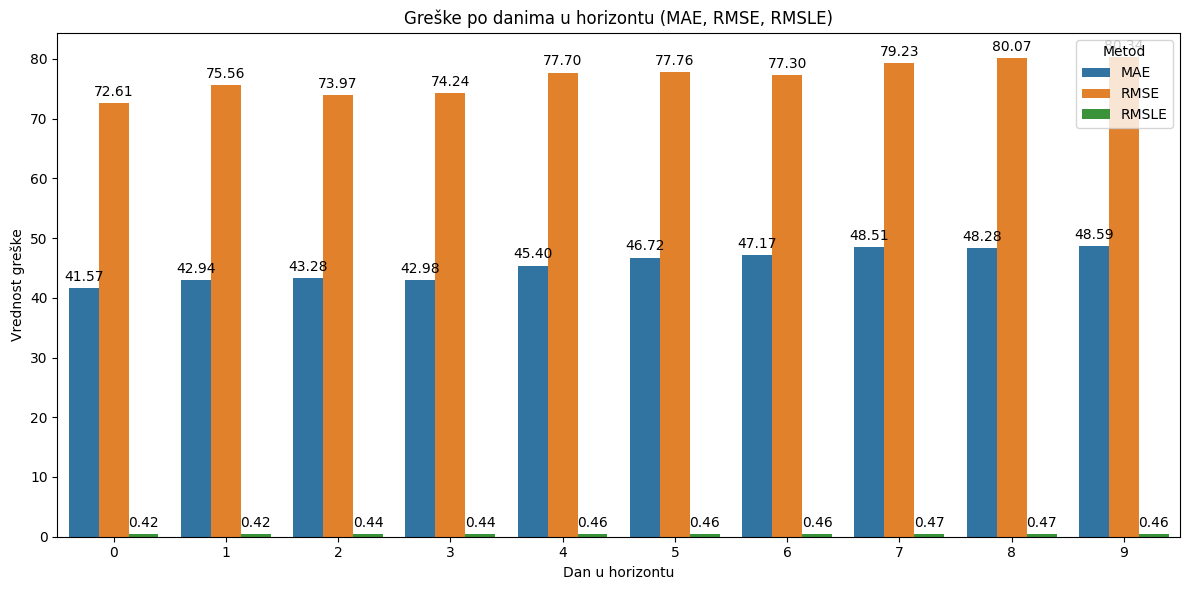

In [22]:
plot_forecast_error_metrics_from_rolling(rolling_df = loaded_model_meteo.rolling_dfs['log'], 
                                             allergen=allergen, 
                                             location=location, 
                                             horizon=10, 
                                             save=False)